In [ ]:
# !pip install pycaret \
#  torch \
#  torchvision \
#  transformers \
#  xgboost \
#  catboost \
#  seaborn 

In [2]:
import pandas as pd 
pd.set_option('display.max_columns', None)  
import matplotlib.pyplot as plt 
from PIL import Image, ImageFile, UnidentifiedImageError
import os
import pycaret 
ImageFile.LOAD_TRUNCATED_IMAGES = True 
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision 
from torchvision import datasets, models, transforms 
from tempfile import TemporaryDirectory 
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset
from torchvision.models import resnet18, resnet50, VGG19_Weights
import warnings
warnings.filterwarnings("ignore")  
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# from sklearn.model_selection import train_test_split
# import mlflow                                   
# import mlflow.pytorch
# Ignorer tous les avertissements
# from torchmetrics.classification import Accuracy
# from efficientnet_pytorch import EfficientNet
# import numpy as np 
# import seaborn as sns
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import pretrainedmodels 

In [3]:
n_files = 34 # Remplace ceci par le nombre exact de fichiers CSV que tu as

# Crée une liste des chemins des fichiers CSV
file_paths = [f'/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/df{i}.csv' for i in range(n_files)]

# Lire les fichiers CSV et stocker les DataFrames dans une liste
list_df = [pd.read_csv(file_path) for file_path in file_paths] 
print(len(list_df))
df_final = pd.concat(list_df, ignore_index=True) 

34


In [4]:
df = df_final.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df["cluster"].value_counts() 

cluster
0    3408
1    1770
2     835
3     484
Name: count, dtype: int64

In [6]:
condition = {0:"0", 1:"1",2:"1",3:"1",}
condition2 = {"0":0, "1":1}
df["cluster"] = df["cluster"].map(condition)
df["cluster"] = df["cluster"].map(condition2)

In [7]:
df["cluster"].value_counts() 

cluster
0    3408
1    3089
Name: count, dtype: int64

In [8]:
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df.drop(columns = [f'feature_{i}' for i in range(2433, 3201)], axis=1)
X = X.drop(columns=['Unnamed: 0', 'id', 'CODEINTE_NUMEPOLI_CODERISQ', 'COUTS_SINISTRES', 'cluster'], axis =1)  # Variables indépendantes


# Charger le modèle PCA
with open('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/ACP_SUP_2_CLASSES.pkl', 'rb') as acp:
    pca = pickle.load(acp)

# Charger le scaler
with open('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/scaler_SUP_2_CLASSES', 'rb') as scale:
    scaler = pickle.load(scale)


# Exemple de transformation avec le PCA et le scaler
X_pca = pca.transform(scaler.transform(X))

In [9]:
# # %%cudf.pandas.profile
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# X = df.drop(columns = [f'feature_{i}' for i in range(2433, 3201)], axis=1)
# X = X.drop(columns=['Unnamed: 0', 'id', 'CODEINTE_NUMEPOLI_CODERISQ', 'COUTS_SINISTRES', 'cluster'], axis =1)  # Variables indépendantes

# # Étape 1 : Normalisation des données
# scaler = StandardScaler() 
# X_scaled = scaler.fit_transform(X)  # Normaliser tes données (X est ton jeu de données)

# # Étape 2 : Application de l'ACP
# pca = PCA(n_components = 0.8)  # Conserver 95% de la variance expliquée
# X_pca = pca.fit_transform(X_scaled) 

# # Afficher la variance expliquée par chaque composante principale
# print("Variance expliquée par chaque composante principale : ", sum(pca.explained_variance_ratio_))
# print("Nombre de composantes principales sélectionnées : ", pca.n_components_)  

In [10]:
# import pickle

# # Enregistrer le modèle
# with open('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/ACP_SUP_2_CLASSES.pkl', 'wb') as acp:
#     pickle.dump(pca, acp)  

# with open('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/scaler_SUP_2_CLASSES', 'wb') as scale:
#     pickle.dump(scaler, scale)  

In [11]:
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df1 = pd.concat([X_pca_df, df[['id', 'CODEINTE_NUMEPOLI_CODERISQ', 'COUTS_SINISTRES', 'cluster']]], axis=1) 
df1.shape

(6497, 763)

In [12]:
df['cluster'].value_counts()

cluster
0    3408
1    3089
Name: count, dtype: int64

In [13]:
df1.to_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/Final_2_CLASSES.csv') 

In [13]:
# df = pd.read_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/.csv') 

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [15]:
df = df1.copy()
from imblearn.over_sampling import SMOTE
from collections import Counter
X = df.drop(columns='cluster')  # Variables indépendantes
y = df['cluster'] 

# # Séparation des données en ensembles d'entraînement et de test
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
X_train, X_test = X_train1.drop(columns=['id', 'CODEINTE_NUMEPOLI_CODERISQ', 'COUTS_SINISTRES']),  X_test1.drop(columns=['id', 'CODEINTE_NUMEPOLI_CODERISQ', 'COUTS_SINISTRES'])

# # Application de SMOTE pour suréchantillonner la classe minoritaire
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Vérifier la distribution des classes après suréchantillonnage
print("Distribution des classes avant suréchantillonnage :", Counter(y_train))
# print("Distribution des classes après suréchantillonnage :", Counter(y_train_resampled)) 

Distribution des classes avant suréchantillonnage : Counter({0: 2556, 1: 2316})


In [16]:
import time
import xgboost as xgb
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold,cross_val_predict, train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression,ElasticNet, Ridge, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [17]:
a = int(np.sqrt(len(X_train.columns))) 
dico = {
    'logistic': LogisticRegression(),
    'elastic': LogisticRegression(penalty="elasticnet", solver="saga"),  #met beaucoup de temps 
    'ridge': LogisticRegression(penalty="l2"),
    'lasso': LogisticRegression(penalty="l1"),
    'Arbre': DecisionTreeClassifier(),
    'Random': RandomForestClassifier(), 
    'xgb': xgb.XGBClassifier(),
    'knn': KNeighborsClassifier(),
    'Gradient_boosting': GradientBoostingClassifier(),
    'adaboost_classifier': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(DecisionTreeClassifier(max_depth=7)), 
    'SVM': SVC(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'lightgbm': LGBMClassifier(),  # Ajout de LightGBM
    'catboost': CatBoostClassifier(verbose=0)  # Ajout de CatBoost
}

param = [ 
    {"C": [0.1], "max_iter": [10000]},
    {"C": [0.1], "l1_ratio": [0.1, 0.5, 0.7], "max_iter": [10000]},
    {"C": [0.1], "solver": ["sag", "lbfgs", "liblinear"], "max_iter": [10000]}, # C grand surapprentissage 
    {"C": [0.1], "solver": ["liblinear"], "max_iter": [10000]},
    {"max_depth": [10], "min_samples_split": [10], "min_samples_leaf": [5]},
    {"n_estimators": [100], "min_samples_leaf": [5], "max_features": [0.6], "max_depth": [10]},
    {'colsample_bytree': [0.6], "n_estimators": [100], "max_depth": [2, 3], "objective":['binary:logistic'], "subsample": [0.7]}, 
    {'n_neighbors': [10, 15], "algorithm": ["auto","ball_tree"]}, # k petit surapprentissage 
    {"n_estimators": [100], "max_depth": [3], "learning_rate": [0.1], "min_samples_split": [10], "min_samples_leaf": [7], "subsample": [0.6]},
    {"n_estimators": [100], "learning_rate": [0.1], "algorithm": ["SAMME", "SAMME.R"]}, #learning_rate petit => sous (0.01) mais fusionner avec beaucpoup d'arbre, grand => surapp, apprend rapidment et mieux avec moins d'arbre 
    {"n_estimators": [100], "max_features": [0.6], "max_samples":[0.6]},
    {"kernel": ['linear', 'rbf'], "C": [0.5], "gamma": ["scale", "auto"]}, #C grand => surapprentisage
    {"solver": ["eigen", "lsqr"], "shrinkage": ["auto"]}, 
    {"reg_param": [1], "tol": [0.05]},
    {"n_estimators": [100], "learning_rate": [0.1], "max_depth": [3], "num_leaves": [10, 15], "colsample_bytree": [0.6], "force_row_wise": [True], 'verbose': [-1], "min_child_samples": [10]},
    {"iterations": [100], "depth": [3], "learning_rate": [0.1], "l2_leaf_reg": [3]} 
] 

In [18]:
# a = int(np.sqrt(len(X_train.columns))) 
# dico = {
#     'logistic': LogisticRegression(),
#     'elastic': LogisticRegression(penalty="elasticnet", solver="saga"),  #met beaucoup de temps 
#     'ridge': LogisticRegression(penalty="l2"),
#     'lasso': LogisticRegression(penalty="l1"),
#     'Arbre': DecisionTreeClassifier(),
#     'Random': RandomForestClassifier(), 
#     'xgb': xgb.XGBClassifier(),
#     'knn': KNeighborsClassifier(),
#     'Gradient_boosting': GradientBoostingClassifier(),
#     'adaboost_classifier': AdaBoostClassifier(),
#     'Bagging': BaggingClassifier(DecisionTreeClassifier(max_depth=7)), 
#     'SVM': SVC(),
#     'LDA': LinearDiscriminantAnalysis(),
#     'QDA': QuadraticDiscriminantAnalysis(),
#     'lightgbm': LGBMClassifier(),  # Ajout de LightGBM
#     'catboost': CatBoostClassifier(verbose=0)  # Ajout de CatBoost
# }

# param = [ 
#     {"C": [0.1], "max_iter": [10000]},
#     {"C": [0.1], "l1_ratio": [0.1, 0.5, 0.7], "max_iter": [10000]},
#     {"C": [0.1], "solver": ["sag", "lbfgs", "liblinear"], "max_iter": [10000]}, # C grand surapprentissage 
#     {"C": [0.1], "solver": ["liblinear"], "max_iter": [10000]},
#     {"max_depth": [10], "min_samples_split": [10], "min_samples_leaf": [5]},
#     {"n_estimators": [300], "min_samples_leaf": [5], "max_features": [0.6], "max_depth": [12]},
#     {'colsample_bytree': [0.6], "n_estimators": [100], "max_depth": [2, 3], "objective":['binary:logistic'], "subsample": [0.7]}, 
#     {'n_neighbors': [10, 15], "algorithm": ["auto","ball_tree"]}, # k petit surapprentissage 
#     {"n_estimators": [300], "max_depth": [3], "learning_rate": [0.1], "min_samples_split": [10], "min_samples_leaf": [7], "subsample": [0.6]},
#     {"n_estimators": [300], "learning_rate": [0.1], "algorithm": ["SAMME", "SAMME.R"]}, #learning_rate petit => sous (0.01) mais fusionner avec beaucpoup d'arbre, grand => surapp, apprend rapidment et mieux avec moins d'arbre 
#     {"n_estimators": [100], "max_features": [0.6], "max_samples":[0.6]},
#     {"kernel": ['linear', 'rbf'], "C": [0.1], "gamma": ["scale", "auto"]}, #C grand => surapprentisage
#     {"solver": ["eigen", "lsqr"], "shrinkage": ["auto"]}, 
#     {"reg_param": [1], "tol": [ 0.05]},
#     {"n_estimators": [300], "learning_rate": [0.1], "max_depth": [3], "num_leaves": [10, 15], "colsample_bytree": [0.6], "force_row_wise": [True], 'verbose': [-1], "min_child_samples": [10]},
#     {"iterations": [300], "depth": [3], "learning_rate": [0.1], "l2_leaf_reg": [3]} 
# ] 

In [19]:
def train_model(nom_model, dico, param, X_train, y_train, kf, out):
    model = dico[nom_model]
    model_cv = GridSearchCV(model, param_grid=param, cv=kf, scoring="accuracy", error_score="raise")  # Utiliser "f1" au lieu de "f1_score"
    temps_debut = time.time() 
    model_cv.fit(X_train, y_train) 
    temps_fin = time.time()
    # temps_execution = temps_fin - temps_debut
    out[nom_model]={"best_model":model_cv.best_estimator_,"meilleurs_parametres":model_cv.best_params_, "Accuracy": model_cv.best_score_,"temps":[time.ctime(temps_debut), time.ctime(temps_fin)]}
    print(f'-----------------  Entrainement de {nom_model} est terminé  -----------------') 

In [20]:
# %%cudf.pandas.profile
import threading
kf = KFold(n_splits=5, shuffle=True, random_state=42)
out = {}
threads = []

# Launch a thread for each model in the dictionary
for i, nom_model in enumerate(dico):
    param_v = param[i]
    thread = threading.Thread(target=train_model, args=(nom_model, dico, param_v, X_train, y_train, kf, out))
    threads.append(thread)
    thread.start() 

In [ ]:
out_1  = pd.DataFrame.from_dict(out, orient='index')
out_1  
# out_1.loc[['lasso','knn'],:].head() 

In [ ]:
# out_1.loc['Random','best_model']

In [ ]:
# Pour s'assurer que tous les threads individuelles soient terminés avant que le thread principal prenne le relai. 
# On en pas besoin si on sait à quel moment tous nos threads vont tous se stopper 

for thread in threads:
    thread.join() 
print(out) 

### CHOIX DU MEILLEUR MODELE 

In [ ]:
def train_best(out, result, position): 
    kf = KFold(n_splits=10, shuffle=True, random_state=42) 
    model = list(out.values())[position]["best_model"] 
    nom = list(out.keys())[position]  
    predictions = cross_val_predict(model, X_train, y_train, cv = kf)
    result[nom] = {"Modele":model, "Accuracy_Score": accuracy_score(y_train, predictions)} 
    print(f'----------------- Entrainement de {nom} est terminé --------------------') 

In [ ]:
result = {}
threads_best = [] 

# Launch a thread for each model in the dictionary
for i, nom_model in enumerate(out):
    position = i
    thread1 = threading.Thread(target=train_best, args=(out, result, position))
    threads_best.append(thread1)
    thread1.start()  

In [63]:
df_result = pd.DataFrame.from_dict(result, orient='index') 
df_result 

""


In [71]:
y_pred = out_1.loc["Random","best_model"].predict(X_test)
f1_test = f1_score(y_test, y_pred, average='weighted')
acc_test = accuracy_score(y_test, y_pred)
print(acc_test) 
# X_train_resampled, y_train_resampled
y_pred1 = out_1.loc["Random","best_model"].predict(X_train)
f1_test = f1_score(y_train, y_pred1, average='weighted')
acc_test = accuracy_score(y_train, y_pred1)
print(acc_test) 

0.6215384615384615
0.9975369458128078


              precision    recall  f1-score   support

           0       0.65      0.65      0.65       852
           1       0.61      0.62      0.62       773

    accuracy                           0.63      1625
   macro avg       0.63      0.63      0.63      1625
weighted avg       0.63      0.63      0.63      1625



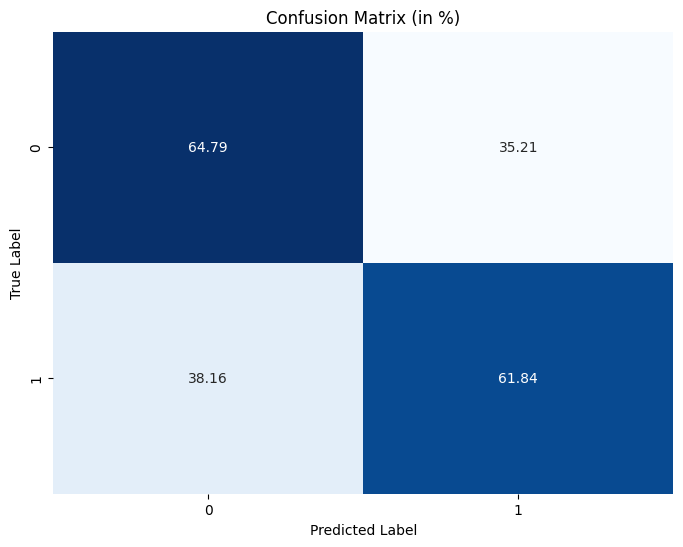

In [45]:
import seaborn as sns 
print(classification_report(y_test, y_pred)) 
cm = confusion_matrix(y_test, y_pred)
# print(classification_report(y_train_resampled, y_pred1)) 
# cm = confusion_matrix(y_train_resampled, y_pred1)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convertir en pourcentages
# Affichage de la matrice de confusion avec les pourcentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (in %)')
plt.show() 

In [246]:
out_1.loc["Bagging","meilleurs_parametres"]
with open('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/Bagging.pkl', 'wb') as bagging:
    pickle.dump(out_1.loc["Bagging","best_model"], bagging)

In [247]:
y_pred

array([2, 3, 2, ..., 0, 0, 0])

In [26]:
y_pred_series = pd.Series(y_pred, index= X_test1.index, name='y_pred')
y_test_series = pd.Series(y_test, index=X_test1.index, name='y_test')
a = pd.concat([X_test1[['id','CODEINTE_NUMEPOLI_CODERISQ','COUTS_SINISTRES']], y_test_series, y_pred_series], axis=1)
a.tail() 

,id,CODEINTE_NUMEPOLI_CODERISQ,COUTS_SINISTRES,y_test,y_pred
4524,10330,2521 4010003368 1,276230.0,0,0
5295,10652,2519 4010001622 1,281141.0,0,0
3161,5069,4600 4000000005 1,250000.0,0,0
5522,11211,2560 4000000025 24,125000.0,0,1
5225,9845,2566 4020000019 1,185000.0,0,0


In [27]:
zero = a[a['y_test']==0]
liste = [1 if pred == lab else 0 for (pred, lab) in zip(list(zero['y_pred']),list(zero['y_test']))]
perf = sum(liste)/len(liste)
print(perf)

0.636150234741784


In [28]:
TP_zero = len(a[(a['y_test']==0) & (a['y_pred']==0)])
FP_zero = len(a[(a['y_pred']==0) & (a['y_test'] != 0)])
FN_zero = len(a[(a['y_pred'] != 0) & (a['y_test'] == 0)])
precision = TP_zero / (TP_zero + FP_zero) 
recall = TP_zero / (TP_zero + FN_zero) 
F1_score = 2*(precision*recall)/(precision+recall)
print(f'Précision: -------------- {precision}') 
print(f'Recall: ------------- {recall}')
print(f'F1_score: ----------- {F1_score}') 

Précision: -------------- 0.6561743341404358
Recall: ------------- 0.636150234741784
F1_score: ----------- 0.6460071513706793


In [236]:
# a['y_pred'].value_counts() 

In [237]:
b = pd.DataFrame({'True_label': y_test}, index=X_test.index)
c = pd.DataFrame({'Predict_label': list(y_pred)}, index=X_test.index)
d = pd.concat([X_test1[["id","CODEINTE_NUMEPOLI_CODERISQ","COUTS_SINISTRES"]], b, c], axis=1)

In [238]:
d.tail() 

,id,CODEINTE_NUMEPOLI_CODERISQ,COUTS_SINISTRES,True_label,Predict_label
3192,4083,2512 4010003785 1,216530.0,0,0
2377,4569,2545 4010002802 1,196403.0,0,0
5124,10461,4578 4000000044 24,125000.0,0,0
2242,392,4612 4010000046 1,87500.0,0,0
6384,13486,3918 4000000014 167,125000.0,0,0


In [239]:
df = d.copy() 
df = df.reset_index(drop=True)
df['Borne_inf'] = 500
df['Borne_sup'] = 333903
df['Moyenne'] = (500 + 333903)/2
for i in range(len(df)):
    if df.loc[i,'Predict_label'] == 1:
        df.loc[i, 'Borne_inf'] = 334000  
        df.loc[i, 'Moyenne'] = (334000 + 725650)/2
        df.loc[i, 'Borne_sup'] = 725650
    if df.loc[i,'Predict_label'] == 2:
        df.loc[i, 'Borne_inf'] = 726000
        df.loc[i, 'Moyenne'] = (726000 + 1236650)/2
        df.loc[i, 'Borne_sup'] = 1236650
    if df.loc[i,'Predict_label'] == 3:
        df.loc[i, 'Borne_inf'] = 1236650
        df.loc[i, 'Moyenne'] = (1236650 + 1883000)/2
        df.loc[i, 'Borne_sup'] = 1883000 

new_row = {col: '' for col in df.columns.difference(['Borne_inf', 'Borne_sup', 'Moyenne'])}
new_row['Borne_inf'] = df['Borne_inf'].sum()
new_row['Borne_sup'] = df['Borne_sup'].sum()
new_row['Moyenne'] = df['Moyenne'].sum()
new_row['COUTS_SINISTRES'] = df['COUTS_SINISTRES'].sum()

# # Ajouter la nouvelle ligne au DataFrame
df.loc['Total'] = new_row

In [240]:
df.tail()

,id,CODEINTE_NUMEPOLI_CODERISQ,COUTS_SINISTRES,True_label,Predict_label,Borne_inf,Borne_sup,Moyenne
1621,4569,2545 4010002802 1,196403.0,0,0,500,333903,167201.5
1622,10461,4578 4000000044 24,125000.0,0,0,500,333903,167201.5
1623,392,4612 4010000046 1,87500.0,0,0,500,333903,167201.5
1624,13486,3918 4000000014 167,125000.0,0,0,500,333903,167201.5
Total,,,748324334.0,,,182824450,760990376,471907413.0


In [241]:
df.to_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/pred.csv')

In [242]:
a = df[df['Predict_label']==0] 

In [243]:
print(a['COUTS_SINISTRES'].sum())
print(a['Borne_inf'].sum())
print(a['Borne_sup'].sum())
print(a['Moyenne'].sum())

print(a['Borne_sup'].sum() / a['COUTS_SINISTRES'].sum())
# print(a['Moyenne'].sum()*0.75)

506942622.0
596000
398012376
199304188.0
0.7851231258278377


In [206]:
df['True_label'].unique()

array([0, 2, 1, 3, ''], dtype=object)

In [221]:
df['True_label'].value_counts()

True_label
0    852
1    443
2    209
3    121
       1
Name: count, dtype: int64

In [223]:
print(a[a['True_label']==0]["COUTS_SINISTRES"].sum())
print(a[a['True_label']==1]["COUTS_SINISTRES"].sum())
print(a[a['True_label']==2]["COUTS_SINISTRES"].sum())
print(a[a['True_label']==3]["COUTS_SINISTRES"].sum())



print(a['COUTS_SINISTRES'].sum())
print(a['Borne_inf'].sum())
print(a['Borne_sup'].sum())
print(a['Moyenne'].sum())


93378321.0
101834031.0
75828606.0
59536989.0
330577947.0
426500
284819259
142622879.5


In [260]:
importances = out_1.loc['Random','best_model'].feature_importances_
indices = np.argsort(importances)[::-1]  # Trier par importance décroissante
top_features = indices[:10]

In [261]:
top_features

array([  0,   1, 190,  47,   6,  11,   2, 580, 478, 599])